# Pandas Express 
# TTC Bus Delays project
### Data Analytics Notebook

### Loading the requried libraries

In [1]:
import numpy as numpy
import pandas as pd
import os
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

Loading just the bus_delay data

In [3]:
bus_delay = pd.read_csv('bus_delay_raw.csv')
bus_delay.head()

C:\Users\ASuS\AppData\Local\Temp\ipykernel_3484\619425570.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  bus_delay = pd.read_csv('bus_delay_raw.csv')


,Unnamed: 0,Route,Day,Location,Incident,Min Delay,Min Gap,Vehicle,Incident ID,DateTime,Direction,copy
0,0,95,Wednesday,York Mills station,Mechanical,10.0,20.0,1734.0,NaN,2014-01-01 00:23:00,NaN,yorkmillsstation
1,1,102,Wednesday,Entire run for route,General Delay,33.0,66.0,8110.0,NaN,2014-01-01 00:55:00,NaN,entirerunforroute
2,2,54,Wednesday,lawrence and Warden,Mechanical,10.0,20.0,7478.0,NaN,2014-01-01 01:28:00,NaN,lawrence&warden
3,3,112,Wednesday,Kipling Station,Emergency Services,18.0,36.0,8084.0,NaN,2014-01-01 01:30:00,NaN,kiplingstation
4,4,24,Wednesday,VP and Ellesmere,Investigation,10.0,20.0,7843.0,NaN,2014-01-01 01:37:00,NaN,ellesmere&victoriapark


### Clean Incident Function Definition
Defining a function to clean the incident types and refine the dataframe by removing typos from the "Incident" column.

In [4]:
def clean_incident_column(df):
    # Replace incidents
    df['Incident'] = df['Incident'].replace({
        'Late Leaving Garage - Operator': 'Late Leaving Garage',
        'Late Leaving Garage - Mechanical': 'Late Leaving Garage',
        'Late Leaving Garage - Management': 'Late Leaving Garage',
        'Late Leaving Garage - Operations': 'Operations - Operator',
        'Late Entering Service - Mechanical': 'Late Leaving Garage',
        'Late Entering Service': 'Late Leaving Garage',
        'Utilizing Off Route': 'Utilized Off Route',
        'Held By': 'General Delay',
        'Cleaning - Unsanitary': 'Cleaning',
        'Cleaning - Disinfection': 'Cleaning',
        'Securitty': 'Security',
        'Road Blocked - NON-TTC Collision': 'Road Block - Non-TTC Collision',
        'Roadblock by Collision - Non-TTC': 'Road Block - Non-TTC Collision',
        'Late Leaving Garage - Vision': 'Vision'
    })

    # Drop specified incidents
    incidents_to_drop = ['e']
    df_filtered = df[~df['Incident'].isin(incidents_to_drop)]

    return df_filtered

Refining the bus_delay data with clean_incident_column function

In [5]:
bus_delay=clean_incident_column(bus_delay)
bus_delay.drop(columns=['Incident ID', 'Direction', 'copy'], inplace=True)

### What Caused the Delays?
Plotting a Pie-chart to show the share of each incident for all the ttc bus delays from 2014 to 2022

In [6]:
import plotly.express as px

df=bus_delay.copy()
Incident_data = df['Incident'].value_counts().reset_index()
Incident_data_major = Incident_data[Incident_data['count'] >= 2000]

# Update the 'Incident' column to 'Other' for incidents with less than 1000 counts
Incident_data['Incident'] = Incident_data.apply(lambda row: 'Other' if row['count'] < 1000 else row['Incident'], axis=1)

# Set the size of the figure using the width and height parameters
fig = px.pie(
    Incident_data,
    names='Incident',
    values='count',
    title='Pie Chart Example',
    width=800,
    height=800,
    color_discrete_sequence=px.colors.qualitative.Set1  # Use a more vibrant color palette
)

fig.update_traces(
    texttemplate='',  # Set the text template to an empty string to hide percentages
    marker=dict(line=dict(color='black', width=2))  # Add borders to the pie chart
)

# Customize the text font
fig.update_layout(font=dict(family='Arial', size=18))



fig.show()


### How has TTC dealt with the Delay Causes?
Plotting a heatmap to show the density of delays per incdient in a seaonal manner

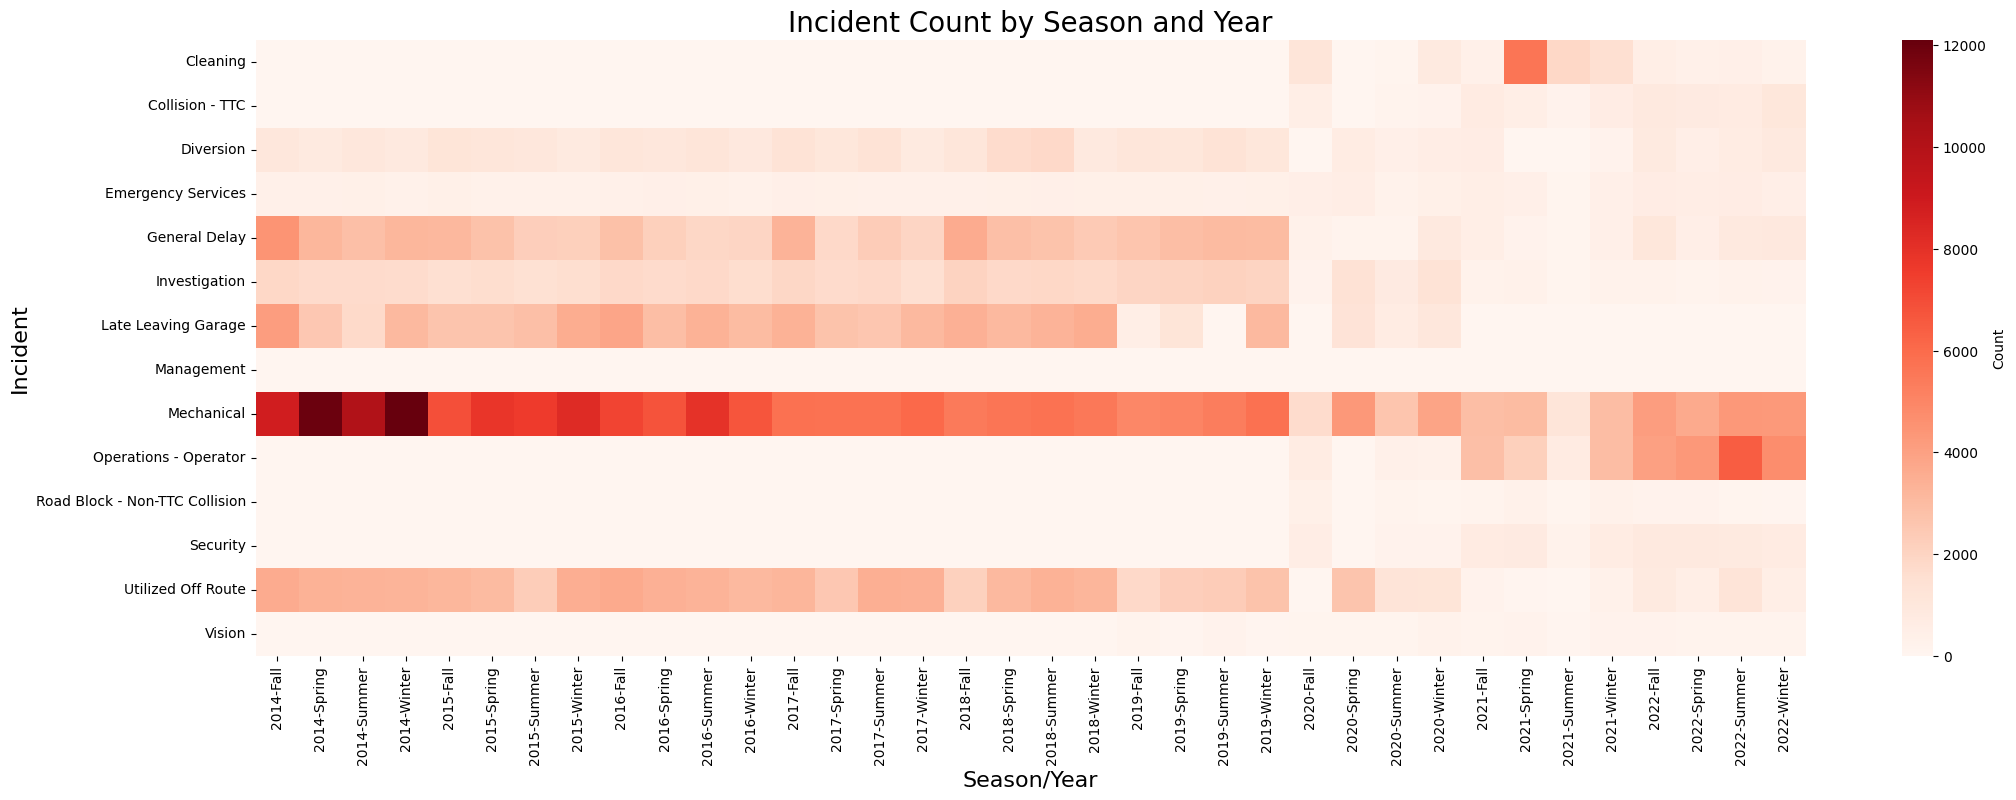

In [22]:
df=bus_delay.copy()

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['DateTime'])

# Extract month and year
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Define a function to map month to season
def month_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'
    
df = clean_incident_column(df)

# Create a new column for the season
df['season'] = df['month'].apply(month_to_season)

# Pivot table to get counts for each incident in each season and year
pivot_table = df.pivot_table(index='Incident', columns=['year', 'season'], aggfunc='size', fill_value=0)

# Plot heatmap without annotations
plt.figure(figsize=(25, 8))
sns.heatmap(pivot_table, annot=False, cmap="Reds", cbar_kws={'label': 'Count'})

# Customize title font size
plt.title('Incident Count by Season and Year', fontsize=20)

# Customize labels font size
plt.xlabel('Season/Year', fontsize=16)
plt.ylabel('Incident', fontsize=16)

plt.show()

### Delay categorization function
Defining a function to categorize delays based on their delay time

In [11]:
def categorize_delays(df, short_threshold=5, medium_threshold=15, long_threshold=30):
    """
    Categorize delays in a DataFrame based on specified thresholds.

    Parameters:
    - df: DataFrame
        The input DataFrame containing the 'Min Delay' column.
    - short_threshold: int, optional (default=5)
        Threshold for short delays.
    - medium_threshold: int, optional (default=15)
        Threshold for medium delays.
    - long_threshold: int, optional (default=30)
        Threshold for long delays.

    Returns:
    DataFrame:
        The input DataFrame with an additional 'Delay_Category' column.
    """
    # Create new column 'Delay_Category' based on delay thresholds
    df['Delay_Category'] = pd.cut(df['Min Delay'],
                                  bins=[-float('inf'), short_threshold, medium_threshold, long_threshold, float('inf')],
                                  labels=['Short', 'Medium', 'Long', 'Crippling'])
    
    return df


Refining the bus_delay dataframe using categorize_delays function

In [12]:
bus_delay = categorize_delays(bus_delay)

Plotting the barline of delays per each month combined with barcharts to show the proportion of each delay type

### How has TTC dealth with delays hostorically?
Plotting a combined line-plot and stacked bar-plots to inspect the history of delays and their categories in TTC bus service. 

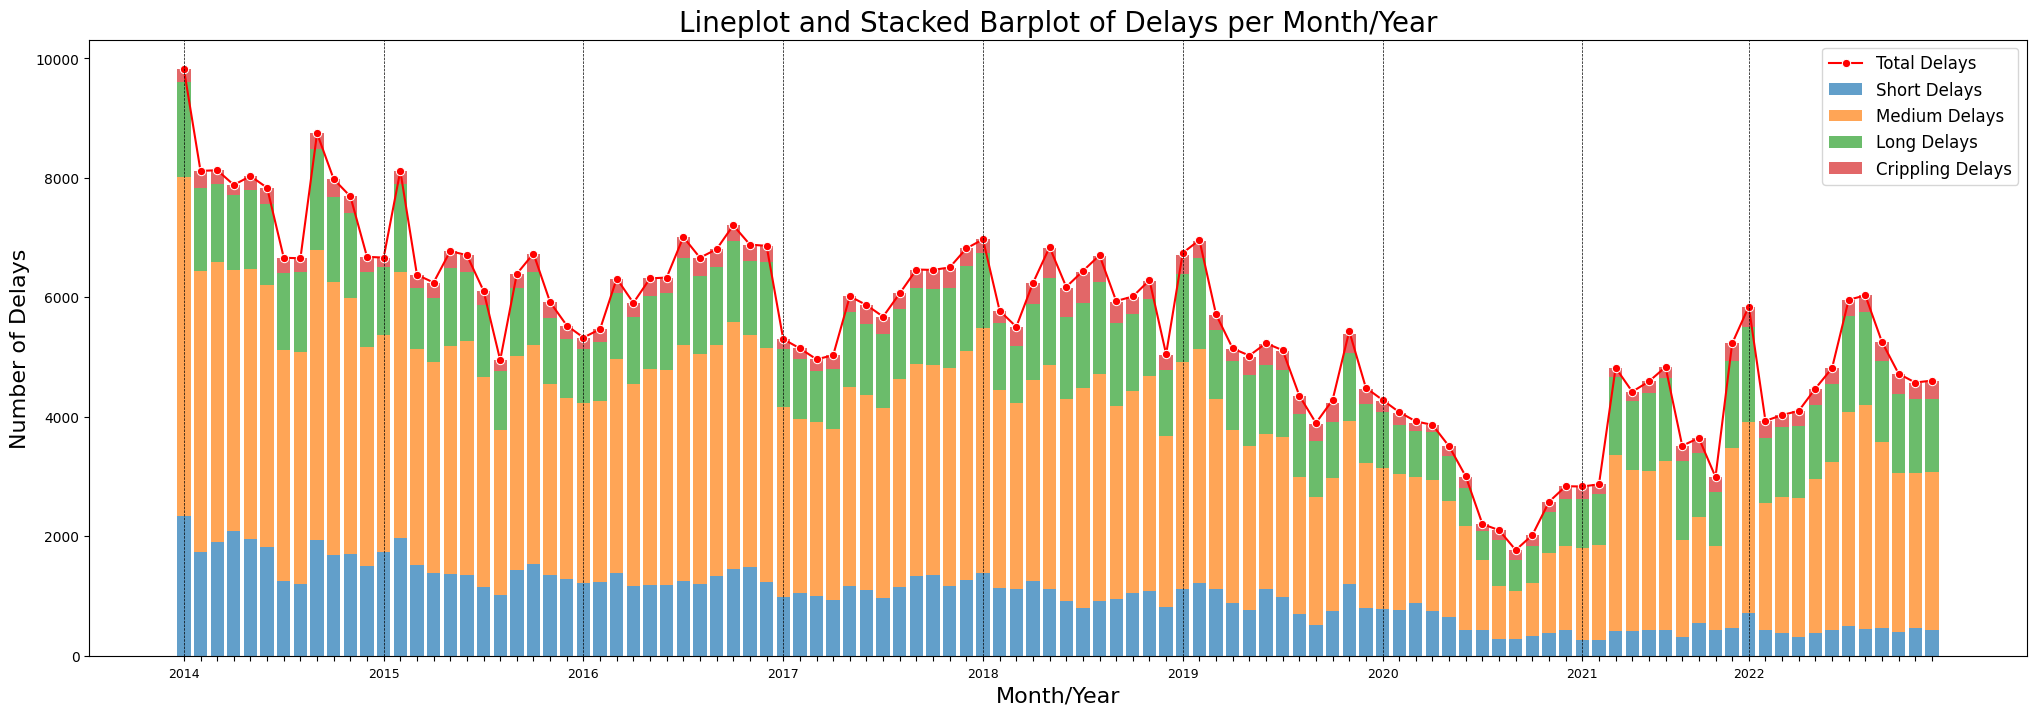

In [44]:
df = bus_delay.copy()
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract month and year, and create a new column 'month_year'
df['month_year'] = df['DateTime'].dt.strftime('%Y-%m')

# Group by 'month_year' and 'Delay_Category' to count delays in each category for each month
date_delay_categories = df.groupby(['month_year', 'Delay_Category']).size().unstack(fill_value=0).reset_index()

# Group by 'month_year' to calculate total delays for each month
date_total_delays = df.groupby('month_year').size().reset_index(name='Total_Delays')

# Merge the DataFrames on 'month_year'
date_delays_2 = pd.merge(date_total_delays, date_delay_categories, how='left', on='month_year')

# Plotting
plt.figure(figsize=(25, 8))

# Line chart for total delays
ax = sns.lineplot(data=date_delays_2, x='month_year', y='Total_Delays', color='red', marker='o', label='Total Delays')

# Stacked bar chart for delay categories
categories = ['Short', 'Medium', 'Long', 'Crippling']
bottom_values = [0] * len(date_delays_2)

for category in categories:
    if category in date_delays_2.columns:
        ax.bar(date_delays_2['month_year'], date_delays_2[category], label=f'{category} Delays', alpha=0.7, bottom=bottom_values)
        bottom_values += date_delays_2[category]

ax.set_title('Lineplot and Stacked Barplot of Delays per Month/Year', fontsize=20)
ax.set_xlabel('Month/Year', fontsize=16)
ax.set_ylabel('Number of Delays', fontsize=16)

# Format x-axis labels with year only changing when it changes
ax.set_xticks(date_delays_2.index)
ax.set_xticklabels([f'{year}' if i == 0 or date_delays_2['month_year'].iloc[i-1].split('-')[0] != year else '' for i, (month, year) in enumerate(zip(date_delays_2['month_year'].str.split('-').str[1], date_delays_2['month_year'].str.split('-').str[0]))], rotation=0, ha='center', fontsize=10)

# Rotate x-axis labels
ax.tick_params(axis='x', which='both', labelsize=9, pad=5)

# Add vertical lines at the beginning of each year
unique_years = date_delays_2['month_year'].str.split('-').str[0].unique()
for year in unique_years:
    first_month_position = date_delays_2[date_delays_2['month_year'].str.startswith(year)].index[0]
    ax.axvline(x=first_month_position, color='black', linestyle='--', linewidth=0.5)

# Display legend and move it to the right
ax.legend(loc='upper right', fontsize=12)

# Show the plot
plt.show()


Doing a Linechart to make to have a better comparison than stacked barcharts

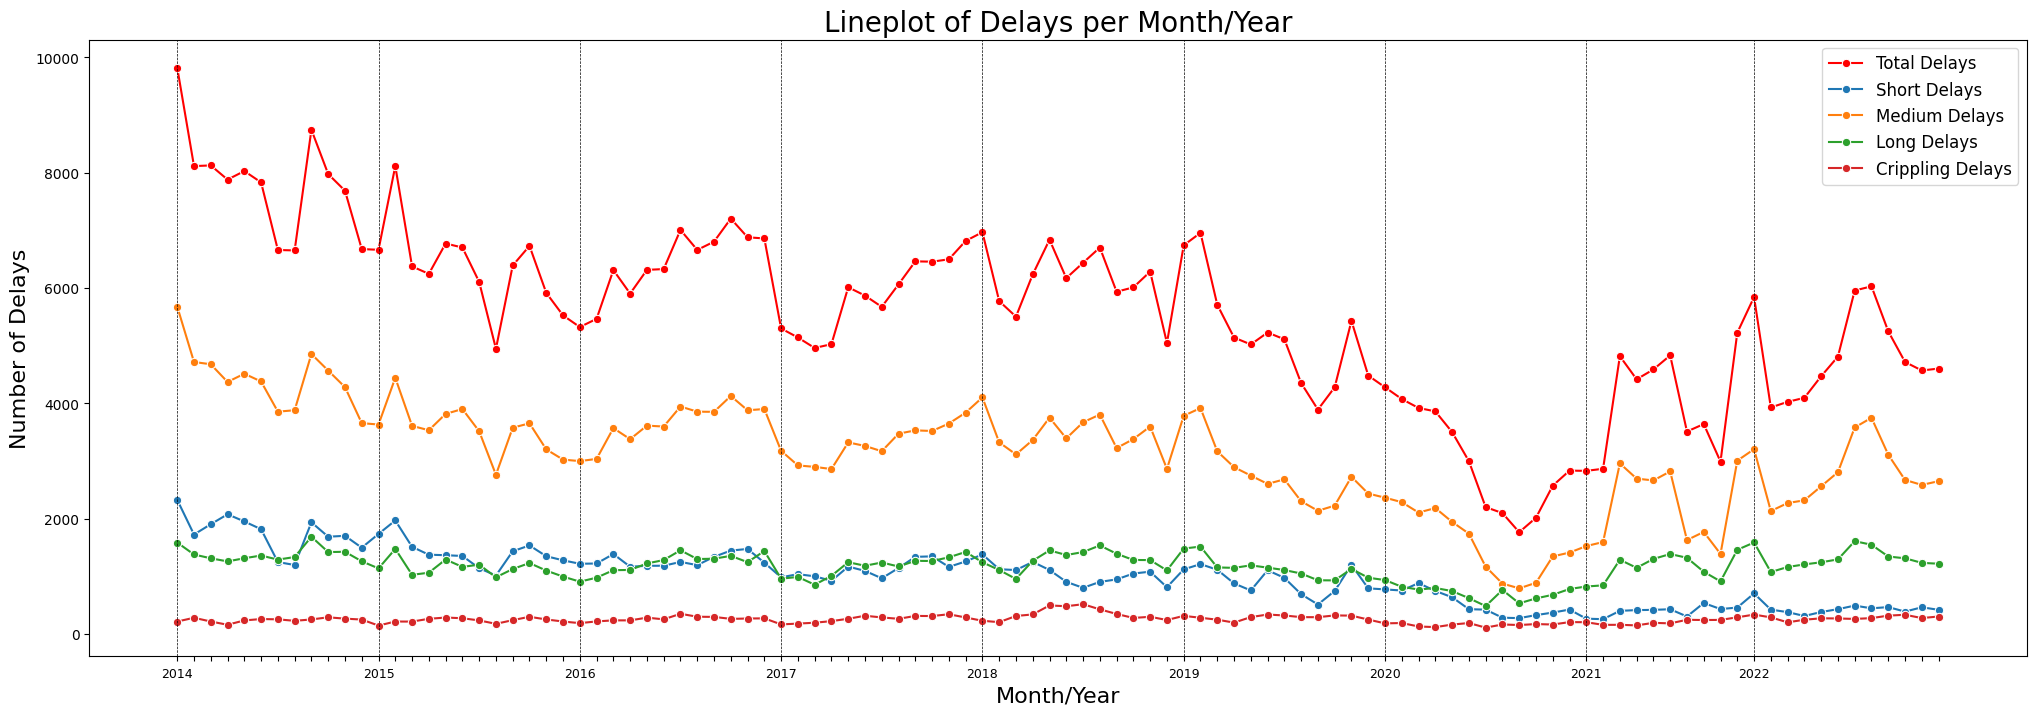

In [45]:
df = bus_delay.copy()
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract month and year, and create a new column 'month_year'
df['month_year'] = df['DateTime'].dt.strftime('%Y-%m')

# Group by 'month_year' and 'Delay_Category' to count delays in each category for each month
date_delay_categories = df.groupby(['month_year', 'Delay_Category']).size().unstack(fill_value=0).reset_index()

# Group by 'month_year' to calculate total delays for each month
date_total_delays = df.groupby('month_year').size().reset_index(name='Total_Delays')

# Merge the DataFrames on 'month_year'
date_delays_2 = pd.merge(date_total_delays, date_delay_categories, how='left', on='month_year')

# Plotting
plt.figure(figsize=(25, 8))

# Line chart for total delays
ax = sns.lineplot(data=date_delays_2, x='month_year', y='Total_Delays', color='red', marker='o', label='Total Delays')

# Line charts for delay categories
categories = ['Short', 'Medium', 'Long', 'Crippling']
for category in categories:
    if category in date_delays_2.columns:
        ax = sns.lineplot(data=date_delays_2, x='month_year', y=category, marker='o', label=f'{category} Delays')

ax.set_title('Lineplot of Delays per Month/Year', fontsize=20)
ax.set_xlabel('Month/Year', fontsize=16)
ax.set_ylabel('Number of Delays', fontsize=16)

# Format x-axis labels with year only changing when it changes
ax.set_xticks(date_delays_2.index)
ax.set_xticklabels([f'{year}' if i == 0 or date_delays_2['month_year'].iloc[i-1].split('-')[0] != year else '' for i, (month, year) in enumerate(zip(date_delays_2['month_year'].str.split('-').str[1], date_delays_2['month_year'].str.split('-').str[0]))], rotation=0, ha='center', fontsize=10)

# Rotate x-axis labels
ax.tick_params(axis='x', which='both', labelsize=9, pad=5)

# Add vertical lines at the beginning of each year
unique_years = date_delays_2['month_year'].str.split('-').str[0].unique()
for year in unique_years:
    first_month_position = date_delays_2[date_delays_2['month_year'].str.startswith(year)].index[0]
    ax.axvline(x=first_month_position, color='black', linestyle='--', linewidth=0.5)

# Display legend and move it to the right
ax.legend(loc='upper right', fontsize=12)

# Show the plot
plt.show()


### What caused each of delay types?
Plotting a heatmap to inspect the causes of each category of delays.

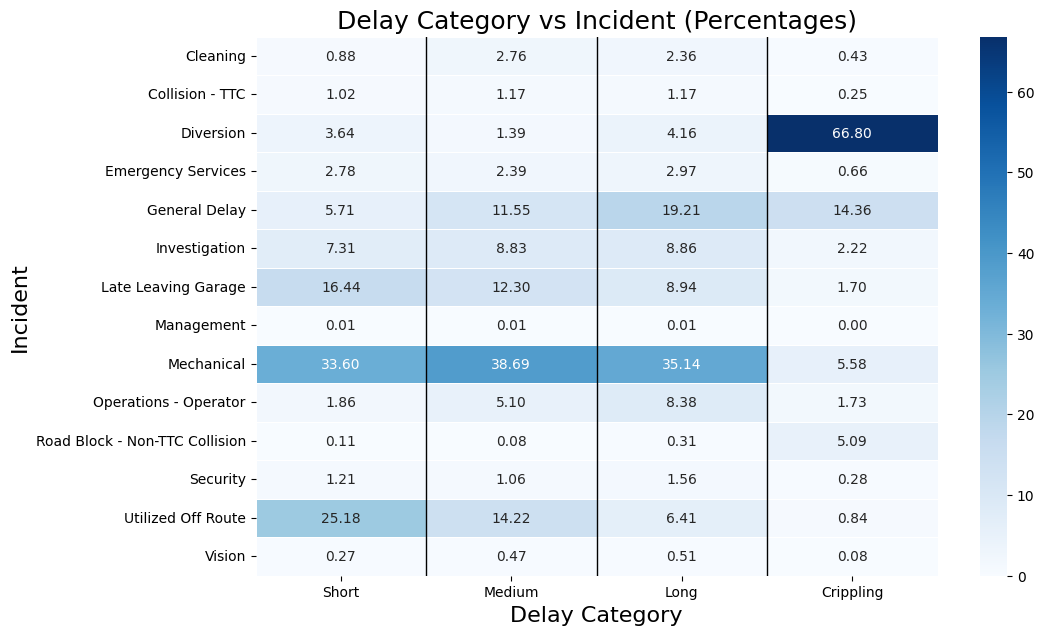

In [10]:
# Creating a copy of the DataFrame
df = bus_delay.copy()

# Grouping data to get total delays and categorize data
total_delays = df.groupby('Delay_Category').size()
categorize_data = df.groupby(['Incident', 'Delay_Category']).size().unstack(fill_value=0)

# Normalize the values in each column to get percentages
normalized_data = categorize_data.div(categorize_data.sum(axis=0), axis=1) * 100

# Plotting the heatmap with normalized values as percentages
plt.figure(figsize=(11, 7))
sns.heatmap(normalized_data,cmap="Blues", annot=True, fmt=".2f", linewidths=.5)

# Add manual vertical lines between columns
for i in range(1, normalized_data.shape[1]):
    plt.axvline(i, color='black', lw=1)

plt.title('Delay Category vs Incident (Percentages)',fontsize=18)
plt.xlabel('Delay Category',fontsize=16)
plt.ylabel('Incident',fontsize=16)
plt.show()

### delay categories Frequency
Plottign a barchart to findout the frequncy of each delay categories

C:\Users\ASuS\AppData\Local\Temp\ipykernel_4300\3147622964.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




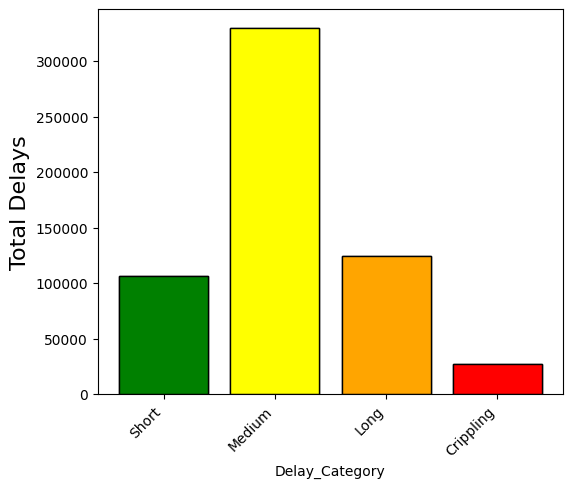

In [31]:
delay_categories_order = ['Short', 'Medium', 'Long', 'Crippling']

# Define colors for each delay category
colors = {'Short': 'green', 'Medium': 'yellow', 'Long': 'orange', 'Crippling': 'red'}

# Calculate total delays for each delay category
total_delays = df['Delay_Category'].value_counts()

# Plotting the bar chart with customized colors, border lines, and width
plt.figure(figsize=(6, 5))

# Use the order parameter to specify the desired order
sns.barplot(x=total_delays.index, y=total_delays.values, order=delay_categories_order, palette=[colors[category] for category in delay_categories_order], edgecolor='black', linewidth=1, capsize=0.1)

# Adjust the width of the bars
bar_width = 0.8  # Adjust as needed
for i, category in enumerate(delay_categories_order):
    plt.bar(i, total_delays[category], color=colors[category], width=bar_width, edgecolor='black', linewidth=1)

# Adding labels and title
#plt.title('Total Delays by Delay Category', fontsize=18)
#plt.xlabel('Delay Category', fontsize=16)
plt.ylabel('Total Delays', fontsize=16)

# Rotating x-axis labels for better readability
plt.xticks(range(len(delay_categories_order)), delay_categories_order, rotation=45, ha='right')

plt.show()

### TTC bus delays' daily trend

This plot shows the dialy number of ttc bus delays. The red lines are markers of red days where total number of daily delays has exceeded 300 delays. 

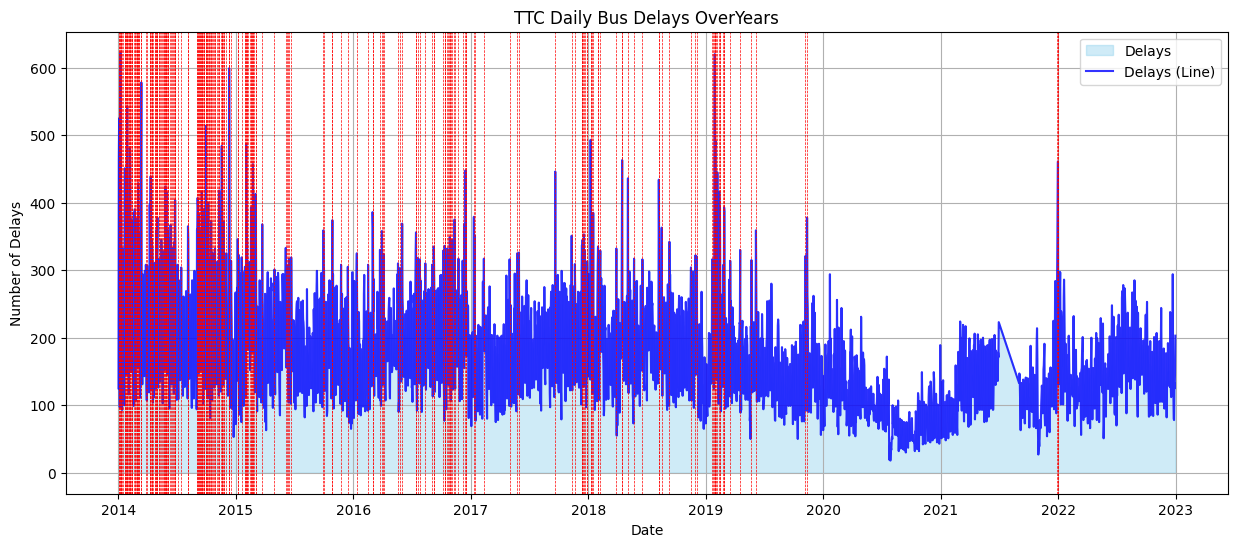

In [18]:
df=bus_delay.copy()
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['just_date'] = df['DateTime'].dt.date
date_delays = df['just_date'].value_counts().reset_index()
date_delays = date_delays.sort_values(by='just_date')

date_delays['just_date'] = pd.to_datetime(date_delays['just_date'])

# Sort the DataFrame by date if it's not already sorted
date_delays = date_delays.sort_values(by='just_date')

# Plotting the area chart
plt.figure(figsize=(15, 6))

# Fill the area with skyblue color for all days
plt.fill_between(date_delays['just_date'], date_delays['count'], color='skyblue', alpha=0.4, label='Delays')

# Plot the line in blue for all days
plt.plot(date_delays['just_date'], date_delays['count'], color='blue', alpha=0.8, label='Delays (Line)')

# Identify and draw a vertical line in red for days with more than 100 delays
high_delay_days = date_delays[date_delays['count'] > 300]
for date in high_delay_days['just_date']:
    plt.axvline(date, color='red', linestyle='--', linewidth=0.5)

plt.xlabel('Date')
plt.ylabel('Number of Delays')
plt.title('TTC Daily Bus Delays OverYears')
plt.legend()
plt.grid(True)
plt.show()

### How frequent are delay types?
This plot shows the frequency od delays based on theid duration and also shows the categorization process

Count the values of delays based on  their duration and category

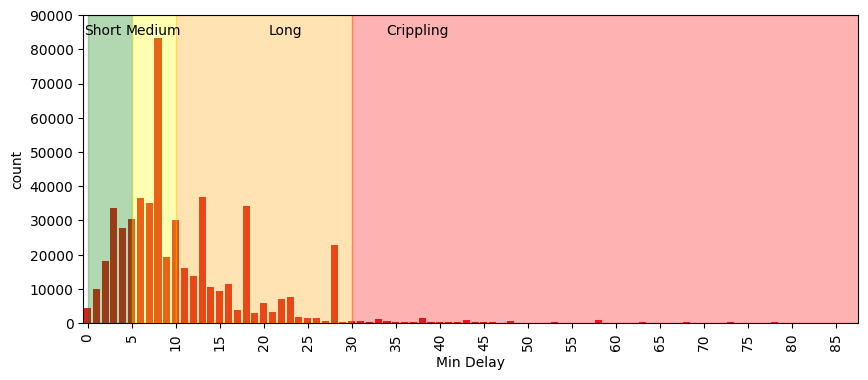

In [19]:
df=bus_delay.copy()
df_duration = df['Min Delay'].value_counts().reset_index()
df_duration = df_duration[(df_duration['Min Delay'] > 1) & (df_duration['Min Delay'] < 90)]
df_duration = df_duration.sort_values(by='Min Delay')

plt.figure(figsize=(10, 4))
ax = sns.barplot(data=df_duration, x='Min Delay', y='count', color='red')
#ax.set(title='TTC BusDelay time frequencies', xlabel='Delay (min)', ylabel='Frequency')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Set x-axis ticks for every 5 minutes
xticks = np.arange(0, 90, 5)
ax.set_ylim(0, 90000)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=90)


# Add regions for short, medium, long, and crippling waiting times
ax.axvspan(0, 5, alpha=0.3, color='green', label='Short')
ax.axvspan(5, 10, alpha=0.3, color='yellow', label='Medium')
ax.axvspan(10, 30, alpha=0.3, color='orange', label='Long')
ax.axvspan(30, 90, alpha=0.3, color='red', label='Crippling')

# Add labels inside the regions
ax.text(1.75, ax.get_ylim()[1] * 0.95, 'Short', ha='center', va='center', color='black')
ax.text(7.5, ax.get_ylim()[1] * 0.95, 'Medium', ha='center', va='center', color='black')
ax.text(22.5, ax.get_ylim()[1] * 0.95, 'Long', ha='center', va='center', color='black')
ax.text(37.5, ax.get_ylim()[1] * 0.95, 'Crippling', ha='center', va='center', color='black')

# Set x-axis limit explicitly to remove gaps
ax.set_xlim(-0.5, len(df_duration) - 0.5)

plt.show()

### Delays frequency based on weekdays

In [20]:
df=bus_delay.copy()
# Define the bins and labels for different delay types
bins = [0, 5, 10, 30, float('inf')]
labels = ['short', 'medium', 'long', 'crippling']

# Create the 'Delay Type' column using pd.cut
df['Delay Type'] = pd.cut(df['Min Delay'], bins=bins, labels=labels, right=False)

# Group by 'Day' and 'Delay Type', and aggregate 'Min Delay' with mean and count
df_weekday_data_1 = df.groupby(['Day', 'Delay Type'])['Min Delay'].agg(['mean', 'count']).unstack('Delay Type').reset_index()

# Flatten the multi-level column index and reset column names
df_weekday_data_1.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in df_weekday_data_1.columns]

df_weekday_data_2 = df.groupby('Day')['Min Delay'].agg(mean_min_delay='mean', count_min_delay='count').reset_index()

df_weekday_data= pd.merge(df_weekday_data_1, df_weekday_data_2, on='Day')

# Define the order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'Day' column to Categorical with the specified order
df_weekday_data['Day'] = pd.Categorical(df_weekday_data['Day'], categories=day_order, ordered=True)

# Sort the DataFrame based on the 'Day' column
df_weekday_data = df_weekday_data.sort_values(by='Day')

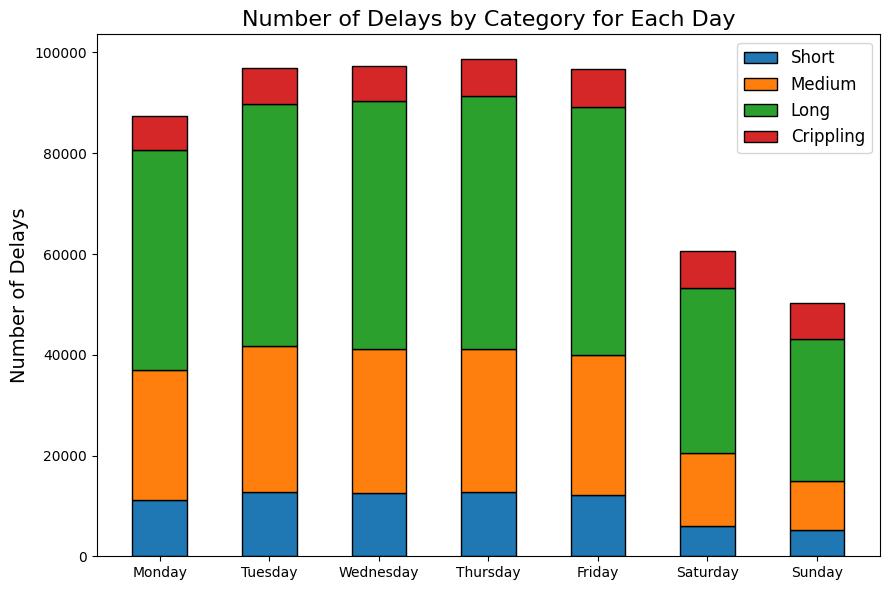

In [21]:
# Plotting
fig, ax = plt.subplots(figsize=(9, 6))

# Bar plot for counts of short, medium, long, crippling with adjusted x positions
bar_width = 0.5  # Adjust the width as needed
bar_positions = np.arange(1, len(df_weekday_data) + 1)

# Bar plot for counts of short, medium, long, crippling
ax.bar(bar_positions , df_weekday_data['count_short'], width=bar_width, label='Short', edgecolor='black')
ax.bar(bar_positions, df_weekday_data['count_medium'], bottom=df_weekday_data['count_short'], width=bar_width, label='Medium', edgecolor='black')
ax.bar(bar_positions, df_weekday_data['count_long'], bottom=df_weekday_data['count_short'] + df_weekday_data['count_medium'], width=bar_width, label='Long', edgecolor='black')
ax.bar(bar_positions, df_weekday_data['count_crippling'], bottom=df_weekday_data['count_short'] + df_weekday_data['count_medium'] + df_weekday_data['count_long'], width=bar_width, label='Crippling', edgecolor='black')

# Customize the plot
ax.set_ylabel('Number of Delays',fontsize=14)
ax.set_title('Number of Delays by Category for Each Day', fontsize=16)
ax.set_xticks(bar_positions)
ax.set_xticklabels(df_weekday_data['Day'])
# Move legend inside the upper right corner
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=12)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

### Top routes with more delays
Since this part is not visually comprehendable, it was removed from the medium article. The alternative is provided in gepspatial visualization

In [29]:
# Group by 'Route' and 'Delay Type', and aggregate 'Min Delay' with mean and count
df_routes_1 = df.groupby(['Route', 'Delay Type'])['Min Delay'].agg(['mean', 'count']).unstack('Delay Type').reset_index()
# Flatten the multi-level column index and reset column names
df_routes_1.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in df_routes_1.columns]

df_routes_2 = df.groupby('Route')['Min Delay'].agg(mean_min_delay='mean', count_min_delay='count').reset_index()

df_routes= pd.merge(df_routes_1, df_routes_2, on='Route')

# Sort the DataFrame based on the 'count_min_delay' column
df_routes = df_routes.sort_values(by='count_min_delay',ascending=False )
df_routes_top20=df_routes.head(20)

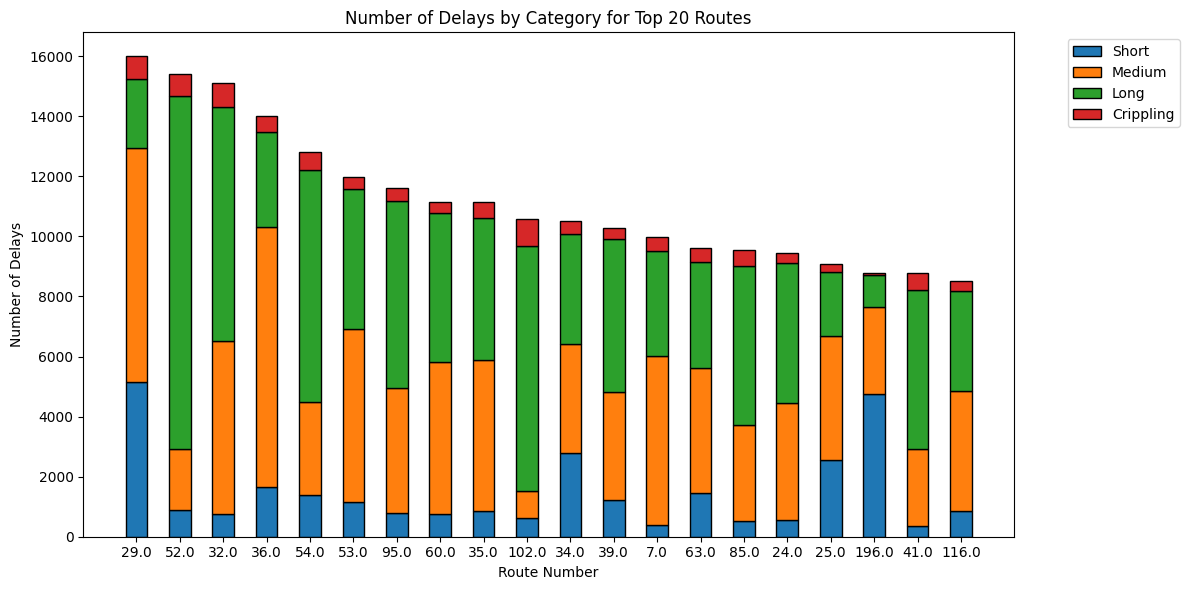

In [30]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for counts of short, medium, long, crippling with adjusted x positions
bar_width = 0.5  # Adjust the width as needed
bar_positions = np.arange(1, len(df_routes_top20) + 1)

# Bar plot for counts of short, medium, long, crippling
ax.bar(bar_positions , df_routes_top20['count_short'], width=bar_width, label='Short', edgecolor='black')
ax.bar(bar_positions, df_routes_top20['count_medium'], bottom=df_routes_top20['count_short'], width=bar_width, label='Medium',edgecolor='black')
ax.bar(bar_positions, df_routes_top20['count_long'], bottom=df_routes_top20['count_short'] + df_routes_top20['count_medium'], width=bar_width, label='Long',edgecolor='black')
ax.bar(bar_positions, df_routes_top20['count_crippling'], bottom=df_routes_top20['count_short'] + df_routes_top20['count_medium'] + df_routes_top20['count_long'], width=bar_width, label='Crippling',edgecolor='black')

# Customize the plot
ax.set_ylabel('Number of Delays')
ax.set_xlabel('Route Number')
ax.set_title('Number of Delays by Category for Top 20 Routes')
ax.set_xticks(bar_positions)
ax.set_xticklabels(df_routes_top20['Route'])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside of the chart border

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

### Loading all_data dataframe
this dataframe contains more columns and all the wearther information are included. 

In [22]:
all_data = pd.read_csv('all_data.csv')
all_data = all_data[all_data['Min Delay'] <= 150]
all_data=clean_incident_column(all_data)
all_data['PRECIP_AMOUNT'].fillna(0, inplace=True)
all_data=categorize_delays(all_data)

C:\Users\ASuS\AppData\Local\Temp\ipykernel_8116\4272613525.py:1: DtypeWarning:

Columns (2,11,34) have mixed types. Specify dtype option on import or set low_memory=False.



In [23]:
all_data.head()

,Unnamed: 0,Unnamed: 0_x,Route,Day,Location,Incident,Min Delay,Min Gap,Vehicle,Incident ID,...,UTC_YEAR,WIND_SPEED,LOCAL_DAY,DEW_POINT_TEMP,LOCAL_MONTH,UTC_DATE,VISIBILITY,weather,time_deviation,Delay_Category
0,0,0,95,Wednesday,York Mills station,Mechanical,10.0,20.0,1734.0,NaN,...,2014,39.0,1,-14.5,1,2014-01-01T06:00:00,16.1,dry,-1 days +23:00:00,Medium
1,1,1,102,Wednesday,Entire run for route,General Delay,33.0,66.0,8110.0,NaN,...,2014,39.0,1,-14.5,1,2014-01-01T06:00:00,16.1,dry,0 days 00:00:00,Crippling
2,2,2,54,Wednesday,lawrence and Warden,Mechanical,10.0,20.0,7478.0,NaN,...,2014,39.0,1,-14.5,1,2014-01-01T06:00:00,16.1,dry,0 days 00:00:00,Medium
3,3,3,112,Wednesday,Kipling Station,Emergency Services,18.0,36.0,8084.0,NaN,...,2014,30.0,1,-14.4,1,2014-01-01T07:00:00,16.1,dry,0 days 00:00:00,Long
4,4,4,24,Wednesday,VP and Ellesmere,Investigation,10.0,20.0,7843.0,NaN,...,2014,30.0,1,-14.4,1,2014-01-01T07:00:00,16.1,dry,0 days 00:00:00,Medium


### Delays & Weather
Average delay time for each cateogy of delays

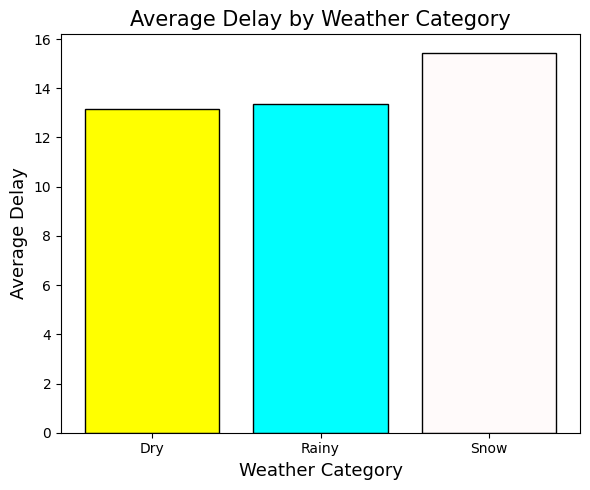

In [24]:
df = all_data.copy()

# Define conditions
conditions = [
    (df['PRECIP_AMOUNT'] == 0),
    (df['PRECIP_AMOUNT'] > 0) & (df['TEMP'] > 0),
    (df['PRECIP_AMOUNT'] > 0) & (df['TEMP'] <= 0)
]

values = ['Dry', 'Rainy', 'Snow']

# Use np.select to apply the conditions and values to create the new column
df['weather_condition'] = np.select(conditions, values, default='Dry')

# Group by 'weather_condition' and calculate the average delay for each category
average_delay_by_weather = df.groupby('weather_condition')['Min Delay'].mean()

# Plotting using Matplotlib
plt.figure(figsize=(6,5))

# Plot a bar chart with the average delay for each weather category
colors = ['yellow', 'aqua', 'snow']
bar_positions = np.arange(len(average_delay_by_weather))

# Adjust the width of the bars
bar_width = 0.4

plt.bar(bar_positions, average_delay_by_weather, color=colors, edgecolor='black')

plt.title('Average Delay by Weather Category', fontsize=15)
plt.xlabel('Weather Category', fontsize=13)
plt.ylabel('Average Delay', fontsize=13)
plt.grid(axis='y')

# Set xticks and xticklabels
plt.xticks(bar_positions, average_delay_by_weather.index)

# Remove grid lines
plt.grid(False, axis='y')

# Adjust the figure size using set_size_inches
fig = plt.gcf()

plt.tight_layout()
plt.show()

### Delays & Incidents
This heatmap shows the share of each incident in each weather cateogry. 

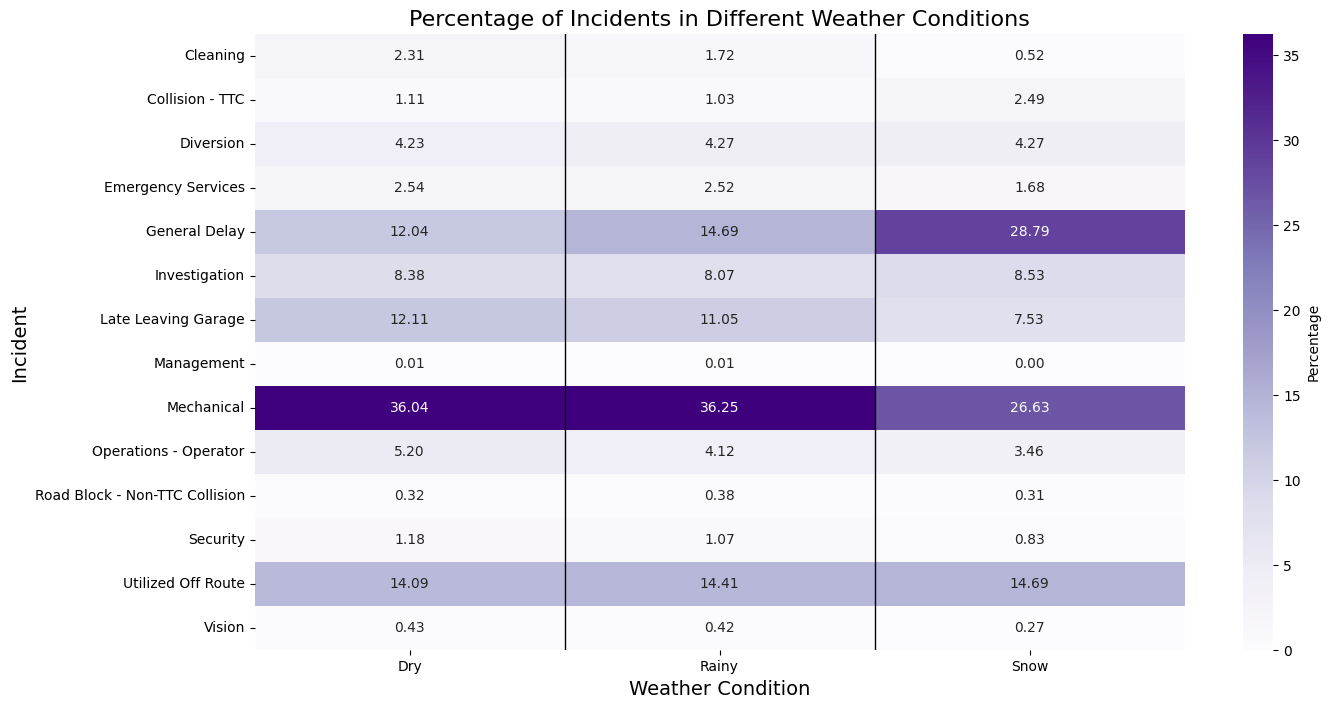

In [25]:
df = all_data.copy()

# Define conditions
conditions = [
    (df['PRECIP_AMOUNT'] == 0),
    (df['PRECIP_AMOUNT'] > 0) & (df['TEMP'] > 0),
    (df['PRECIP_AMOUNT'] > 0) & (df['TEMP'] <= 0)
]

values = ['Dry', 'Rainy', 'Snow']

# Use np.select to apply the conditions and values to create the new column
df['weather_condition'] = np.select(conditions, values, default='Dry')

# Create a pivot table to get 'Incident' on one axis, 'weather_condition' on the other, and calculate percentages
incident_weather_counts = df.groupby(['Incident', 'weather_condition']).size().reset_index(name='count')
incident_weather_pivot = incident_weather_counts.pivot_table(index='Incident', columns='weather_condition', values='count', fill_value=0)

# Calculate percentages correctly across columns
incident_weather_percentage = incident_weather_pivot.div(incident_weather_pivot.sum(axis=0), axis=1) * 100

# Plotting the single heatmap with 'Reds' color palette and manual vertical lines between columns
plt.figure(figsize=(15, 8))
sns.heatmap(incident_weather_percentage, cmap="Purples", annot=True, fmt=".2f", cbar_kws={'label': 'Percentage'})

# Add manual vertical lines between columns
for i in range(1, len(incident_weather_percentage.columns)):
    plt.axvline(i, color='black', lw=1)

plt.title('Percentage of Incidents in Different Weather Conditions', fontsize=16)
plt.xlabel('Weather Condition', fontsize=14)
plt.ylabel('Incident', fontsize=14)
plt.show()